In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
# If the observations are in a dataframe, you can use statsmodels.formulas.api to do the regression instead
from statsmodels import regression
import matplotlib.pyplot as plt


Let's say Y is our actual data, and Y_hat is the predictions made by linear regression.

In [2]:
Y = np.array([1, 3.5, 4, 8, 12])
Y_hat = np.array([1, 3, 5, 7, 9])

print('Error ' + str(Y_hat - Y))

# Compute squared error
SE = (Y_hat - Y) ** 2

print('Squared Error ' + str(SE))
print('Sum Squared Error ' + str(np.sum(SE)))

Error [ 0.  -0.5  1.  -1.  -3. ]
Squared Error [0.   0.25 1.   1.   9.  ]
Sum Squared Error 11.25


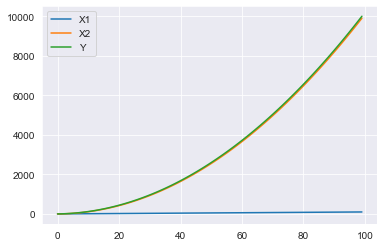

In [3]:
# Construct a simple linear curve of 1, 2, 3, ...
X1 = np.arange(100)

# Make a parabola and add X1 to it, this is X2
X2 = np.array([i ** 2 for i in range(100)]) + X1

# This is our real Y, constructed using a linear combination of X1 and X2
Y = X1 + X2

plt.plot(X1, label='X1')
plt.plot(X2, label='X2')
plt.plot(Y, label='Y')
plt.legend();

In [4]:
# Use column_stack to combine independent variables, then add a column of ones so we can fit an intercept
X = sm.add_constant( np.column_stack( (X1, X2) ) )

# Run the model
results = regression.linear_model.OLS(Y, X).fit()

print('Beta_0:', results.params[0])
print('Beta_1:', results.params[1])
print('Beta_2:', results.params[2])

Beta_0: 2.3305801732931286e-12
Beta_1: 1.0000000000003872
Beta_2: 0.9999999999999951


The same care must be taken with these results as with partial derivatives. The formula for $Y$ is ostensibly

$$X_1 + X_2 = X_1 + X^2 + X_1 = 2 X_1 + X^2$$

However, the coefficient of $X_1$ is 1. That is because $Y$ changes by 1 if we change $X_1$ by 1 <i>while holding $X_2$ constant</i>. Multiple linear regression separates out contributions from different variables.

Similarly, running a linear regression on two securities might give a high $\\beta$. However, if we bring in a third security (like SPY, which tracks the S&P 500) as an independent variable, we may find that the correlation between the first two securities is almost entirely due to them both being correlated with the S&P 500. This is useful because the S&P 500 may then be a more reliable predictor of both securities than they were of each other. This method allows us to better gauge the significance between the two securities and prevent confounding the two variables.

In [6]:
# Load pricing data for two arbitrarily-chosen assets and SPY
import pandas_datareader as pdr

data_spy = pdr.get_data_yahoo('SPY')
benchmark = data_spy["Open"]

data_dtv = pdr.get_data_yahoo('AAPL')
asset1 = data_dtv["Open"]

data_dtv = pdr.get_data_yahoo('FISV')
asset2 = data_dtv["Open"]


# First, run a linear regression on the two assets
slr = regression.linear_model.OLS(asset1, sm.add_constant(asset2)).fit()
print('SLR beta of asset2:', slr.params[1])

SLR beta of asset2: 1.795561182509127


In [7]:
# Run multiple linear regression using asset2 and SPY as independent variables
mlr = regression.linear_model.OLS(asset1, sm.add_constant(np.column_stack((asset2, benchmark)))).fit()

prediction = mlr.params[0] + mlr.params[1]*asset2 + mlr.params[2]*benchmark
prediction.name = 'Prediction'

print('MLR beta of asset2:', mlr.params[1], '\nMLR beta of S&P 500:', mlr.params[2])

MLR beta of asset2: 0.0037861827741564437 
MLR beta of S&P 500: 0.6498377034239394


The next step after running an analysis is determining if we can even trust the results. A good first step is checking to see if anything looks weird in graphs of the independent variables, dependent variables, and predictions.

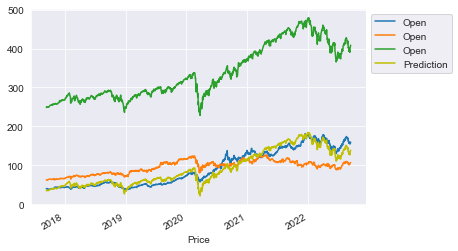

In [8]:
# Plot the three variables along with the prediction given by the MLR
asset1.plot()
asset2.plot()
benchmark.plot()
prediction.plot(color='y')
plt.xlabel('Price')
plt.legend(bbox_to_anchor=(1,1), loc=2);

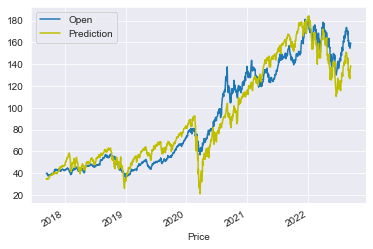

In [9]:
# Plot only the dependent variable and the prediction to get a closer look
asset1.plot()
prediction.plot(color='y')
plt.xlabel('Price')
plt.legend();

In [10]:
mlr.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Open   R-squared:                       0.924
Model:                            OLS   Adj. R-squared:                  0.923
Method:                 Least Squares   F-statistic:                     7575.
Date:                Mon, 12 Sep 2022   Prob (F-statistic):               0.00
Time:                        15:48:07   Log-Likelihood:                -4998.8
No. Observations:                1258   AIC:                         1.000e+04
Df Residuals:                    1255   BIC:                         1.002e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -127.4435      2.163    -58.927      0.000    -131.687    -123.201
x1             0.0038      0.029      0.129      0.897      -0.054       0.061
x2             0.6498      0.007     91.093      0.000       0.636       0.664
==============================================================================
Omnibus:                       94.152   Durbin-Watson:                   0.018
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               85.886
Skew:                           0.574   Prob(JB):                     2.24e-19
Kurtosis:                       2.432   Cond. No.                     2.12e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.12e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Model Assumptions
The validity of these statistics depends on whether or not the assumptions of the linear regression model are satisfied. These are:

The independent variable is not random.
The variance of the error term is constant across observations. This is important for evaluating the goodness of the fit.
The errors are not autocorrelated. The Durbin-Watson statistic reported by the regression detects this. If it is close to , there is no autocorrelation.
The errors are normally distributed. If this does not hold, we cannot use some of the statistics, such as the F-test.

Multiple linear regression also requires an additional assumption:

There is no exact linear relationship between the independent variables. Otherwise, it is impossible to solve for the coefficients
 uniquely, since the same linear equation can be expressed in multiple ways.

If there is a linear relationship between any set of independent variables, also known as covariance, we say that they are linear combinations of each other

Basically it means that you don't really need more than one of the vars if they are not independent or are correlated to one another. You can just par them down until you get the one that best describes that set of feature space. Since that one var contains information that all the other vars had

While our coefficients may be nondescriptive, the ultimate model may still be accurate provided that there is a good overall fit between the independent variables and the dependent variables. The best practice for constructing a model where dependence is a problem is to leave out the less descriptive variables that are correlated with the better ones. This improves the model by reducing the chances of overfitting while bringing the
 estimates closer to their true values.

If we confirm that the necessary assumptions of the regression model are satisfied, we can safely use the statistics reported to analyze the fit. For example, the $R^2$ value tells us the fraction of the total variation of $Y$ that is explained by the model. When doing multiple linear regression, however, we prefer to use adjusted $R^2$, which corrects for the small increases in $R^2$ that occur when we add more regression variables to the model, even if they are not significantly correlated with the dependent variable. Adjusted $R^2$ is defined as
When deciding on the best possible model of your dependent variables, there are several different methods to turn to. If you use too many explanatory variables, you run the risk of overfitting your model, but if you use too few you may end up with a terrible fit. One of the most prominent methods to decide on a best model is stepwise regression. Forward stepwise regression starts from an empty model and tests each individual variable, selecting the one that results in the best model quality, usually measured with AIC or BIC (lowest is best). It then adds the remaining variables one at a time, testing each subsequent combination of explanatory variables in a regression and calculating the AIC or BIC value at each step. At the end of the regression, the model with the best quality (according to the given measure) is selected and presented as a the final, best model. This does have limitations, however. It does not test every single possible combination of variables so it may miss the theoretical best model if a particular variable was written off earlier in performing the algorithm. As such, stepwise regression should be used in combination with your best judgment regarding the model.

AKA when the pain in the ass truly begins


Model Selection Example

When deciding on the best possible model of your dependent variables, there are several different methods to turn to. If you use too many explanatory variables, you run the risk of overfitting your model, but if you use too few you may end up with a terrible fit. One of the most prominent methods to decide on a best model is stepwise regression. Forward stepwise regression starts from an empty model and tests each individual variable, selecting the one that results in the best model quality, usually measured with AIC or BIC (lowest is best). It then adds the remaining variables one at a time, testing each subsequent combination of explanatory variables in a regression and calculating the AIC or BIC value at each step. At the end of the regression, the model with the best quality (according to the given measure) is selected and presented as a the final, best model. This does have limitations, however. It does not test every single possible combination of variables so it may miss the theoretical best model if a particular variable was written off earlier in performing the algorithm. As such, stepwise regression should be used in combination with your best judgment regarding the model.

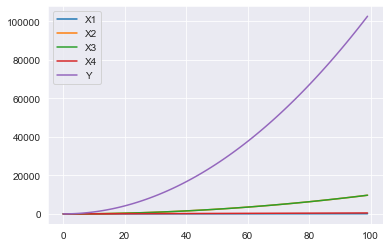

In [11]:
X1 = np.arange(100)
X2 = [i**2 for i in range(100)] - X1
X3 = [np.log(i) for i in range(1, 101)] + X2
X4 = 5 * X1
Y = 2 * X1 + 0.5 * X2 + 10 * X3 + X4

plt.plot(X1, label='X1')
plt.plot(X2, label='X2')
plt.plot(X3, label='X3')
plt.plot(X4, label='X4')
plt.plot(Y, label='Y')
plt.legend();

In [12]:
results = regression.linear_model.OLS(Y, sm.add_constant(np.column_stack((X1,X2,X3,X4)))).fit()

print("Beta_0: ", results.params[0])
print("Beta_1: ", results.params[1])
print("Beta_2: ", results.params[2])
print("Beta_3: ", results.params[3])
print("Beta_4: ", results.params[4])

Beta_0:  1.6825651982799172e-11
Beta_1:  0.2692307692306919
Beta_2:  0.4999999999972715
Beta_3:  9.999999999994543
Beta_4:  1.3461538461539249


In [13]:
data = pd.DataFrame(np.column_stack((X1,X2,X3,X4)), columns = ['X1','X2','X3','X4'])
response = pd.Series(Y, name='Y')

In [14]:
def forward_aic(response, data):
    # This function will work with pandas dataframes and series

    # Initialize some variables
    explanatory = list(data.columns)
    selected = pd.Series(np.ones(data.shape[0]), name="Intercept")
    current_score, best_new_score = np.inf, np.inf

    # Loop while we haven't found a better model
    while current_score == best_new_score and len(explanatory) != 0:

        scores_with_elements = []
        count = 0

        # For each explanatory variable
        for element in explanatory:
            # Make a set of explanatory variables including our current best and the new one
            tmp = pd.concat([selected, data[element]], axis=1)
            # Test the set
            result = regression.linear_model.OLS(Y, tmp).fit()
            score = result.aic
            scores_with_elements.append((score, element, count))
            count += 1

        # Sort the scoring list
        scores_with_elements.sort(reverse = True)
        # Get the best new variable
        best_new_score, best_element, index = scores_with_elements.pop()
        if current_score > best_new_score:
            # If it's better than the best add it to the set
            explanatory.pop(index)
            selected = pd.concat([selected, data[best_element]],axis=1)
            current_score = best_new_score
    # Return the final model
    model = regression.linear_model.OLS(Y, selected).fit()
    return model

In [15]:
result = forward_aic(Y, data)
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 6.421e+25
Date:                Mon, 12 Sep 2022   Prob (F-statistic):               0.00
Time:                        15:55:59   Log-Likelihood:                 1622.1
No. Observations:                 100   AIC:                            -3236.
Df Residuals:                      96   BIC:                            -3226.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -3.32e-11   1.54e-08     -0.002      0.998   -3.06e-08    3.05e-08
X3            10.0000   9.31e-09   1.07e+09      0.000      10.000      10.000
X1             0.2692   2.84e-11   9.47e+09      0.000       0.269       0.269
X2             0.5000    9.3e-09   5.37e+07      0.000       0.500       0.500
X4             1.3462   1.42e-10   9.47e+09      0.000       1.346       1.346
==============================================================================
Omnibus:                       14.041   Durbin-Watson:                   0.001
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               10.015
Skew:                           0.650   Prob(JB):                      0.00669
Kurtosis:                       2.155   Cond. No.                     5.85e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.11e-26. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In the construction of this model, the $X_4$ term is highly closely related to the $X1$ term, simply multiplying it by a scalar. However, stepwise regression did not catch this and remove the variable and simply adjust the coefficient of the $X_1$ term. Our own judgment would say to leave the $X_4$ term out of the model, showing the limitations of stepwise regression.